In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import cifar10

Using TensorFlow backend.


# Load Dataset

In [0]:
train_xs = np.load('./train_caches.npy')
test_xs = np.load('./test_caches.npy')
(x_train, train_ys), (x_test, test_ys) = cifar10.load_data()
n_classes = 10

# reshape
test_ys = test_ys.reshape(-1)
train_ys = train_ys.reshape(-1)

# Data provider

In [0]:
import numpy as np
import random

class DataProvider(object):
    def __init__(self, images, labels):
        self.n_sample = len(labels)
        self.queue = list(range(self.n_sample))
        random.shuffle(self.queue)

        self.images = images
        self.labels = labels
        self.epoch_count = 0

    def next_batch(self, batch_size):
        if len(self.queue) < batch_size:
            self.queue = list(range(self.n_sample))
            self.epoch_count += 1
        target_indices = self.queue[:batch_size]
        del self.queue[:batch_size]
        return self.images[target_indices], self.labels[target_indices]

# Modeling

In [4]:
graph = tf.Graph()

with graph.as_default() :
    xs = tf.placeholder(dtype = tf.float32, shape = [None,2048])
    ys = tf.placeholder(dtype = tf.int32 , shape=[None])
    lr = tf.placeholder(dtype = tf.float32, shape = [])
    
    n_units=[1024, 1024]
    layer = xs 
    for ind, units in enumerate(n_units):
        with tf.variable_scope('layer_{}'.format(ind)):
            layer = tf.layers.Dense(units, tf.nn.relu,
                                tf.initializers.he_normal)(layer)
    logits = tf.layers.Dense(n_classes)(layer)

W0718 08:43:58.830440 140625781921664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Loss

In [5]:
with graph.as_default() :
    loss = tf.losses.sparse_softmax_cross_entropy(ys, logits)
    loss = tf.identity(loss, 'loss')

W0718 08:43:59.131798 140625781921664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Prediction

In [0]:
with graph.as_default() :
    pred = tf.nn.softmax(logits)

## Metric

In [0]:
with graph.as_default() :
    # metric
    logits_cls = tf.argmax(logits, axis=1)
    logits_cls = tf.cast(logits_cls, dtype=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(ys, logits_cls),tf.float32),
                         name='acc')

## Optimizer

In [0]:
with graph.as_default() :    
    train_op = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9).minimize(loss)

## Open Session

In [0]:
with graph.as_default() :    

    sess = tf.Session()
    init = tf.group(tf.global_variables_initializer(),
                    tf.local_variables_initializer())
    # saver 
    sess.run(init)

## Training

In [0]:
#log list
train_loss_ch = []
train_acc_ch = []
val_loss_ch = []
val_acc_ch = []

In [0]:
# hparam 
batch_size = 100
min_loss = 1000000.0
learning_rate = 0.0001
max_iter = 5000

dataprovider = DataProvider(images=train_xs, labels=train_ys)

In [16]:
with graph.as_default() :
    for i in range(max_iter):
        # extract batch_xs, batch_ys
        batch_xs, batch_ys = dataprovider.next_batch(batch_size)

        # Training 
        sess.run(train_op, {xs: batch_xs, ys: batch_ys, lr: learning_rate})
        
        # Validation 
        if i % 100 == 0 :
            # Validate validation dataset 
            fetches=[loss, acc]
            val_loss, val_acc = sess.run(fetches, 
                                         {xs: test_xs, ys: test_ys})
            val_loss_ch.append(val_loss)
            val_acc_ch.append(val_acc)

            # Validate train dataset : extract randomly 10000 samples from train dataset 
            batch_xs, batch_ys = dataprovider.next_batch(10000)
            train_loss, train_acc = sess.run(fetches,{xs: batch_xs, ys: batch_ys})
            train_loss_ch.append(train_loss)
            train_acc_ch.append(train_acc)

            print('step : {} train loss : {:.4f} acc : {:.4f} | Val loss : {:.4f} acc : {:.4f}'.\
            format(i, train_loss, train_acc, val_loss, val_acc))

step : 0 train loss : 0.0328 acc : 0.9948 | Val loss : 0.3379 acc : 0.9075
step : 100 train loss : 0.0329 acc : 0.9943 | Val loss : 0.3344 acc : 0.9087
step : 200 train loss : 0.0254 acc : 0.9967 | Val loss : 0.3344 acc : 0.9084
step : 300 train loss : 0.0357 acc : 0.9932 | Val loss : 0.3352 acc : 0.9082
step : 400 train loss : 0.0381 acc : 0.9915 | Val loss : 0.3350 acc : 0.9088
step : 500 train loss : 0.0262 acc : 0.9967 | Val loss : 0.3356 acc : 0.9088
step : 600 train loss : 0.0251 acc : 0.9970 | Val loss : 0.3357 acc : 0.9085
step : 700 train loss : 0.0263 acc : 0.9968 | Val loss : 0.3346 acc : 0.9077
step : 800 train loss : 0.0346 acc : 0.9936 | Val loss : 0.3355 acc : 0.9086
step : 900 train loss : 0.0367 acc : 0.9924 | Val loss : 0.3354 acc : 0.9087
step : 1000 train loss : 0.0256 acc : 0.9970 | Val loss : 0.3359 acc : 0.9086
step : 1100 train loss : 0.0250 acc : 0.9970 | Val loss : 0.3361 acc : 0.9081
step : 1200 train loss : 0.0266 acc : 0.9969 | Val loss : 0.3351 acc : 0.908

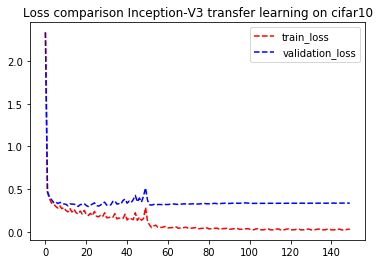

In [38]:
plt.title("Loss comparison Inception-V3 transfer learning on cifar10")
plt.plot(train_loss_ch, 'r--', label = 'train_loss')
plt.plot(val_loss_ch, 'b--', label = 'validation_loss')
plt.legend()

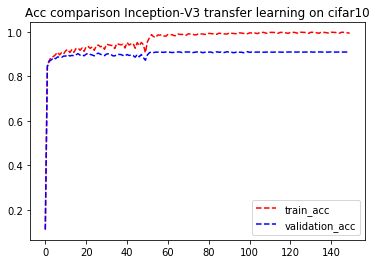

In [39]:
plt.title("Acc comparison Inception-V3 transfer learning on cifar10")
plt.plot(train_acc_ch, 'r--', label = 'train_acc')
plt.plot(val_acc_ch, 'b--', label = 'validation_acc')
plt.legend()